*Some parts of code were copied from [decision_tree_alexander_merdian_tarko.ipynb](https://github.com/OmdenaAI/Dryad/blob/02b0007b9a3615b793727952bc5f23dc48ceb05b/decision_tree_alexander_merdian-tarko/decision_tree_alexander_merdian-tarko.ipynb)*


**DATASET:**<br> 
v1-B <br>
**FEATURES:**<br> 
gas_scan_0 - gas_scan_9 (suggested to exclude humidity and temperature)



# **0. IMPORT LIBRARIES**

In [242]:
# import libraries

import pickle
from datetime import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RandomizedSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve

# **1. LOAD DATA**

In [243]:
train_url = 'https://drive.google.com/uc?id=1r8xfRQIeA00sgt_CKU-WwsXBbjeZip2g'
val_url = 'https://drive.google.com/uc?id=1EkNEn3mok3CVrz8mwBpoxJGQPUReCJ2u'
test_url = 'https://drive.google.com/uc?id=1C5tjrnpq75skQy8-Q7xbXxOOJIVtkY_h'

In [244]:
# load data

train = pd.read_csv(train_url) 
val = pd.read_csv(val_url) 
test = pd.read_csv(test_url)

In [245]:
# train data preview

train.head()

,sensor_node_id,scan_time,temp_0,temp_1,temp_2,temp_3,temp_4,temp_5,temp_6,temp_7,temp_8,temp_9,humid_0,humid_1,humid_2,humid_3,humid_4,humid_5,humid_6,humid_7,humid_8,humid_9,gas_scan_0,gas_scan_1,gas_scan_2,gas_scan_3,gas_scan_4,gas_scan_5,gas_scan_6,gas_scan_7,gas_scan_8,gas_scan_9,gas_scan_cnt,encoded_specimen,trigger,burn_material,burn_material_amount(g),end_time,hotplate_start,hotplate_temp,experiment,sensor_hotplate_distance,start_time,venue
0,137,2021-09-01 09:02:12.939383029+00:00,19.2,19.4,20.0,20.0,20.1,20.4,20.5,20.5,20.7,20.8,74,74,72,72,72,71,70,70,69,69,30291600,76400,1823600,69300,294100,252400,234800,69000,160600,200800,1,0,manual,SP2,600.0,2021-09-01 18:50:46+00:00,2021-09-01 10:03:57+00:00,500,6,30m,2021-09-01 08:30:22+00:00,hall
1,137,2021-09-01 09:02:49.563847064+00:00,19.6,19.7,20.2,20.2,20.3,20.6,20.6,20.6,20.8,20.9,69,70,70,70,69,69,69,69,68,68,102400000,144100,4785000,120800,577300,472900,416600,106100,196100,224900,2,0,manual,SP2,600.0,2021-09-01 18:50:46+00:00,2021-09-01 10:03:57+00:00,500,6,30m,2021-09-01 08:30:22+00:00,hall
2,137,2021-09-01 09:03:26.179350+00:00,19.6,19.8,20.3,20.3,20.4,20.6,20.7,20.7,20.9,20.9,69,69,69,69,69,69,68,68,68,68,102400000,160600,5610900,133400,649900,532300,466800,115400,208000,238800,3,0,manual,SP2,600.0,2021-09-01 18:50:46+00:00,2021-09-01 10:03:57+00:00,500,6,30m,2021-09-01 08:30:22+00:00,hall
3,137,2021-09-01 09:04:02.821827+00:00,19.7,19.9,20.4,20.4,20.5,20.7,20.7,20.7,20.9,21.0,68,68,69,69,69,68,68,68,68,67,102400000,167900,6073700,139100,682400,560300,489200,119000,215000,245100,4,0,manual,SP2,600.0,2021-09-01 18:50:46+00:00,2021-09-01 10:03:57+00:00,500,6,30m,2021-09-01 08:30:22+00:00,hall
4,137,2021-09-01 09:04:39.888919115+00:00,19.7,19.9,20.4,20.4,20.5,20.7,20.8,20.8,21.0,21.0,68,68,69,68,69,68,68,68,68,67,102400000,156300,5593700,131700,645000,528200,465800,114900,214900,245500,5,0,manual,SP2,600.0,2021-09-01 18:50:46+00:00,2021-09-01 10:03:57+00:00,500,6,30m,2021-09-01 08:30:22+00:00,hall


In [246]:
# validation data preview

val.head()

,sensor_node_id,scan_time,temp_0,temp_1,temp_2,temp_3,temp_4,temp_5,temp_6,temp_7,temp_8,temp_9,humid_0,humid_1,humid_2,humid_3,humid_4,humid_5,humid_6,humid_7,humid_8,humid_9,gas_scan_0,gas_scan_1,gas_scan_2,gas_scan_3,gas_scan_4,gas_scan_5,gas_scan_6,gas_scan_7,gas_scan_8,gas_scan_9,gas_scan_cnt,encoded_specimen,trigger,burn_material,burn_material_amount(g),end_time,hotplate_start,hotplate_temp,experiment,sensor_hotplate_distance,start_time,venue
0,139,2021-09-01 08:58:37.190576076+00:00,18.9,19.0,19.6,19.6,19.7,20.0,20.1,20.0,20.2,20.3,75,75,73,73,73,72,71,71,70,70,102400000,153100,5097600,132800,661900,525300,461400,118300,250700,301900,1,0,manual,SP2,600.0,2021-09-01 18:50:46+00:00,2021-09-01 10:03:57+00:00,500,6,30m,2021-09-01 08:30:22+00:00,hall
1,139,2021-09-01 08:59:13.819256067+00:00,19.2,19.3,19.8,19.8,19.9,20.1,20.2,20.2,20.4,20.4,70,70,70,70,70,70,69,69,69,69,102400000,228100,9009600,192600,1033200,811500,692800,160300,290400,331200,2,0,manual,SP2,600.0,2021-09-01 18:50:46+00:00,2021-09-01 10:03:57+00:00,500,6,30m,2021-09-01 08:30:22+00:00,hall
2,139,2021-09-01 08:59:50.441437959+00:00,19.3,19.4,19.9,19.9,20.0,20.2,20.3,20.3,20.4,20.5,69,69,69,69,69,69,69,69,69,68,102400000,252500,10590800,211700,1155700,916700,779500,174400,306000,345700,3,0,manual,SP2,600.0,2021-09-01 18:50:46+00:00,2021-09-01 10:03:57+00:00,500,6,30m,2021-09-01 08:30:22+00:00,hall
3,139,2021-09-01 09:00:27.082521915+00:00,19.3,19.5,20.0,20.0,20.0,20.3,20.3,20.3,20.5,20.5,69,69,69,69,69,69,69,68,68,68,102400000,261600,11303200,219400,1214300,972900,821800,180900,313600,354300,4,0,manual,SP2,600.0,2021-09-01 18:50:46+00:00,2021-09-01 10:03:57+00:00,500,6,30m,2021-09-01 08:30:22+00:00,hall
4,139,2021-09-01 09:01:04.330970+00:00,19.4,19.5,20.0,20.0,20.1,20.3,20.4,20.3,20.5,20.6,69,69,69,69,69,69,68,68,68,68,102400000,255400,11074000,218000,1204700,962600,814400,178600,313600,356100,5,0,manual,SP2,600.0,2021-09-01 18:50:46+00:00,2021-09-01 10:03:57+00:00,500,6,30m,2021-09-01 08:30:22+00:00,hall


In [247]:
# test data preview

test.head()

,sensor_node_id,scan_time,temp_0,temp_1,temp_2,temp_3,temp_4,temp_5,temp_6,temp_7,temp_8,temp_9,humid_0,humid_1,humid_2,humid_3,humid_4,humid_5,humid_6,humid_7,humid_8,humid_9,gas_scan_0,gas_scan_1,gas_scan_2,gas_scan_3,gas_scan_4,gas_scan_5,gas_scan_6,gas_scan_7,gas_scan_8,gas_scan_9,gas_scan_cnt,encoded_specimen,trigger,burn_material,burn_material_amount(g),end_time,hotplate_start,hotplate_temp,experiment,sensor_hotplate_distance,start_time,venue
0,146,2021-09-01 09:01:36.817528009+00:00,18.8,19.0,19.6,19.6,19.7,20.0,20.1,20.1,20.3,20.4,74,74,72,72,72,71,70,70,69,69,102400000,198100,7285000,168200,855800,692100,613100,150400,300900,364900,1,0,manual,SP2,600.0,2021-09-01 18:50:46+00:00,2021-09-01 10:03:57+00:00,500,6,30m,2021-09-01 08:30:22+00:00,hall
1,146,2021-09-01 09:02:13.375891+00:00,19.2,19.3,19.8,19.8,19.9,20.2,20.2,20.2,20.4,20.5,69,69,69,69,69,69,68,68,68,68,102400000,293900,13181000,254800,1375800,1115100,971500,216100,358000,416900,2,0,manual,SP2,600.0,2021-09-01 18:50:46+00:00,2021-09-01 10:03:57+00:00,500,6,30m,2021-09-01 08:30:22+00:00,hall
2,146,2021-09-01 09:02:50.057426+00:00,19.3,19.4,19.9,19.9,20.0,20.3,20.3,20.3,20.5,20.5,68,68,68,68,68,68,68,68,67,67,102400000,329300,15918300,286200,1618300,1293700,1126200,241500,392200,440300,3,0,manual,SP2,600.0,2021-09-01 18:50:46+00:00,2021-09-01 10:03:57+00:00,500,6,30m,2021-09-01 08:30:22+00:00,hall
3,146,2021-09-01 09:03:26.565743+00:00,19.3,19.5,20.0,20.0,20.1,20.3,20.4,20.3,20.5,20.6,68,68,68,68,68,68,68,67,67,67,102400000,350300,17541700,300900,1726800,1395500,1204700,254200,408900,453400,4,0,manual,SP2,600.0,2021-09-01 18:50:46+00:00,2021-09-01 10:03:57+00:00,500,6,30m,2021-09-01 08:30:22+00:00,hall
4,146,2021-09-01 09:04:03.635421991+00:00,19.4,19.5,20.0,20.0,20.1,20.4,20.4,20.4,20.6,20.6,68,68,68,68,68,68,67,67,67,67,102400000,343900,17305500,296200,1697800,1378600,1195200,252000,408200,456800,5,0,manual,SP2,600.0,2021-09-01 18:50:46+00:00,2021-09-01 10:03:57+00:00,500,6,30m,2021-09-01 08:30:22+00:00,hall


# **2. PREPROCESSING**

In [248]:
# data dimension

print(train.shape)
print(val.shape)
print(test.shape)

(1389, 44)
(458, 44)
(651, 44)


In [249]:
# features to be used 

features = ['gas_scan_0',
            'gas_scan_1',
            'gas_scan_2',
            'gas_scan_3',
            'gas_scan_4',
            'gas_scan_5',
            'gas_scan_6',
            'gas_scan_7',
            'gas_scan_8',
            'gas_scan_9']

In [250]:
train[features].describe()

,gas_scan_0,gas_scan_1,gas_scan_2,gas_scan_3,gas_scan_4,gas_scan_5,gas_scan_6,gas_scan_7,gas_scan_8,gas_scan_9
count,1.389000e+03,1.389000e+03,1.389000e+03,1389.000000,1.389000e+03,1.389000e+03,1.389000e+03,1389.000000,1389.000000,1389.000000
mean,7.726707e+07,2.684839e+05,1.305161e+07,231628.077754,1.349370e+06,1.108435e+06,9.598739e+05,192347.804176,311405.111591,353153.563715
std,3.703501e+07,2.243366e+05,1.642560e+07,206853.871846,1.437282e+06,1.252976e+06,1.116439e+06,174801.720743,206169.728688,223863.503941
min,2.130000e+04,5.600000e+03,8.000000e+03,5600.000000,7.400000e+03,6.900000e+03,7.000000e+03,5600.000000,20800.000000,27900.000000
25%,4.783640e+07,9.160000e+04,1.394100e+06,70900.000000,2.936000e+05,2.025000e+05,1.662000e+05,60000.000000,148600.000000,173500.000000
50%,1.024000e+08,1.782000e+05,5.305600e+06,144200.000000,6.824000e+05,5.270000e+05,4.338000e+05,115300.000000,235100.000000,276700.000000
75%,1.024000e+08,4.159000e+05,1.976350e+07,349600.000000,2.010300e+06,1.662600e+06,1.417300e+06,284100.000000,453100.000000,515800.000000
max,1.024000e+08,1.107000e+06,8.555610e+07,967400.000000,7.095700e+06,6.176800e+06,5.448600e+06,797800.000000,926000.000000,989100.000000


In [251]:
# splitting predictor and target variable

X_train = train[features]
y_train = train['encoded_specimen']

X_val = val[features]
y_val = val['encoded_specimen']

In [252]:
scaler = StandardScaler()

X_train_scale = scaler.fit_transform(X_train)
X_val_scale = scaler.transform(X_val)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


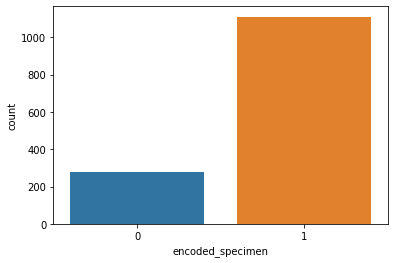

In [253]:
# target variable distribution in train data

sns.countplot(y_train)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


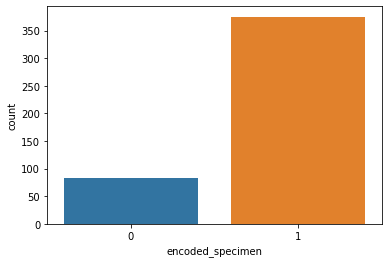

In [254]:
# target variable distribution in validation data

sns.countplot(y_val)

# **3. MODELING**

In [255]:
def knn_modeling(X_train, y_train, X_val, y_val):

  # defining model
  knn = KNeighborsClassifier()

  # hyperparameter tuning
  param = {
    'n_neighbors':[3,4,5,6,7,8,9,10],
    'p':[1,2],
  }

  grid_search = GridSearchCV(knn, param, scoring='f1', cv=5)

  # training and finding best parameter
  start = datetime.now()
  grid_search.fit(X_train, y_train)
  duration = datetime.now()-start

  # best model
  best_knn = grid_search.best_estimator_

  # predicting 
  y_pred = best_knn.predict(X_val)

  # metrics
  tn, fp, fn, tp = confusion_matrix(y_val, y_pred).ravel()

  print('Confusion matrix: \n', confusion_matrix(y_val, y_pred),'\n') # confusion matrix
  print('Classification report: \n', classification_report(y_val, y_pred),'\n') # classification report
  print('Precision: {:0.2f}%'.format(round(precision_score(y_val, y_pred), 4)*100)) # precision
  print('Recall: {:0.2f}%'.format(round(recall_score(y_val, y_pred), 4)*100)) # recall
  print('Specificity: {:0.2f}%'.format(round(tn/(tn+fp), 4)*100)) # specificity
  print('F1-Score: {:0.2f}%'.format(round(f1_score(y_val, y_pred), 4)*100)) # f1-score

  y_pred_proba = best_knn.predict_proba(X_val)[:, 1]
  print('AUC: {:0.3f}'.format(round(roc_auc_score(y_val, y_pred_proba), 4))) # auc

  # plot ROC curve
  baseline = [0 for _ in range(len(y_val))]
  baseline_auc = roc_auc_score(y_val, baseline)
  baseline_fpr, baseline_tpr, _ = roc_curve(y_val, baseline)
  rf_fpr, rf_tpr, _ = roc_curve(y_val, y_pred_proba)

  plt.figure(figsize=(12,8))
  plt.plot(baseline_fpr, baseline_tpr, linestyle='--', label='Baseline')
  plt.plot(rf_fpr, rf_tpr, marker='.', label='Model')
  plt.title('ROC Curve Validation Set')
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.legend()
  plt.show()

  # model size
  print('Model size in kilobytes: {}'.format(sys.getsizeof(pickle.dumps(best_knn)) / 1000))

  # training duration
  print('Model training time in seconds: {}.{}'.format(duration.seconds,duration.microseconds))

Confusion matrix: 
 [[ 10  73]
 [ 16 359]] 

Classification report: 
               precision    recall  f1-score   support

           0       0.38      0.12      0.18        83
           1       0.83      0.96      0.89       375

    accuracy                           0.81       458
   macro avg       0.61      0.54      0.54       458
weighted avg       0.75      0.81      0.76       458
 

Precision: 83.10%
Recall: 95.73%
Specificity: 12.05%
F1-Score: 88.97%
AUC: 0.617


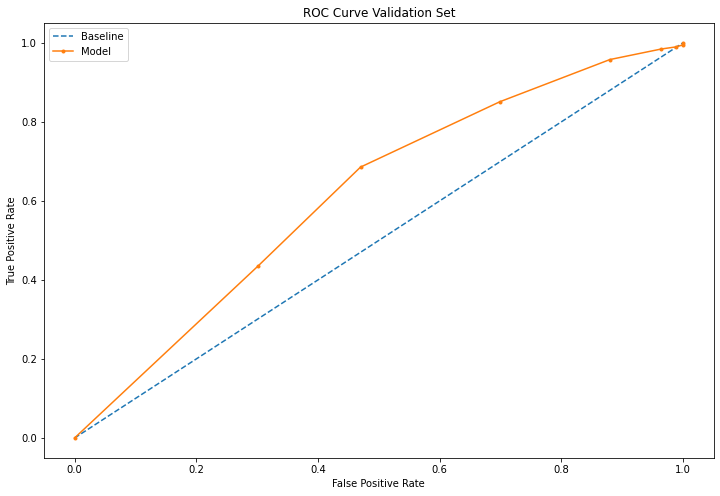

Model size in kilobytes: 257.979
Model training time in seconds: 0.971897


In [256]:
# training and testing on scaled data

knn_modeling(X_train_scale, y_train, X_val_scale, y_val)

Confusion matrix: 
 [[ 11  72]
 [ 22 353]] 

Classification report: 
               precision    recall  f1-score   support

           0       0.33      0.13      0.19        83
           1       0.83      0.94      0.88       375

    accuracy                           0.79       458
   macro avg       0.58      0.54      0.54       458
weighted avg       0.74      0.79      0.76       458
 

Precision: 83.06%
Recall: 94.13%
Specificity: 13.25%
F1-Score: 88.25%
AUC: 0.598


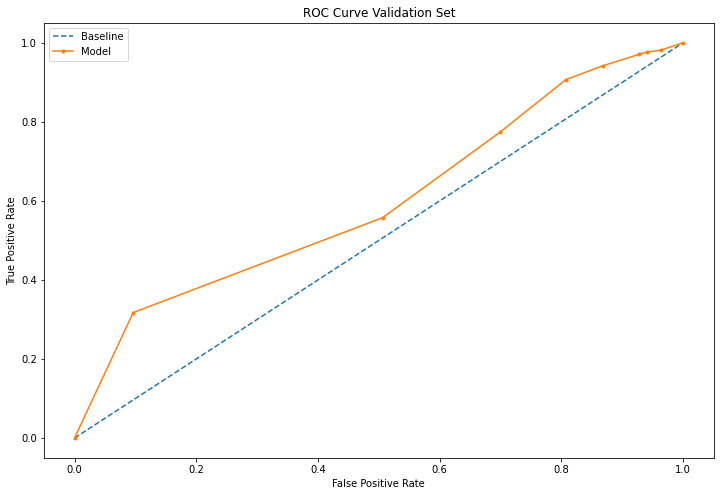

Model size in kilobytes: 257.979
Model training time in seconds: 1.82778


In [257]:
# training and testing on unscaled data

knn_modeling(X_train, y_train, X_val, y_val)